# Анализ временного ряда

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2025-03-27 10:27:00--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2025-03-27 10:27:00 (19.8 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



In [55]:
df = pd.read_csv("airline-passengers.csv")
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


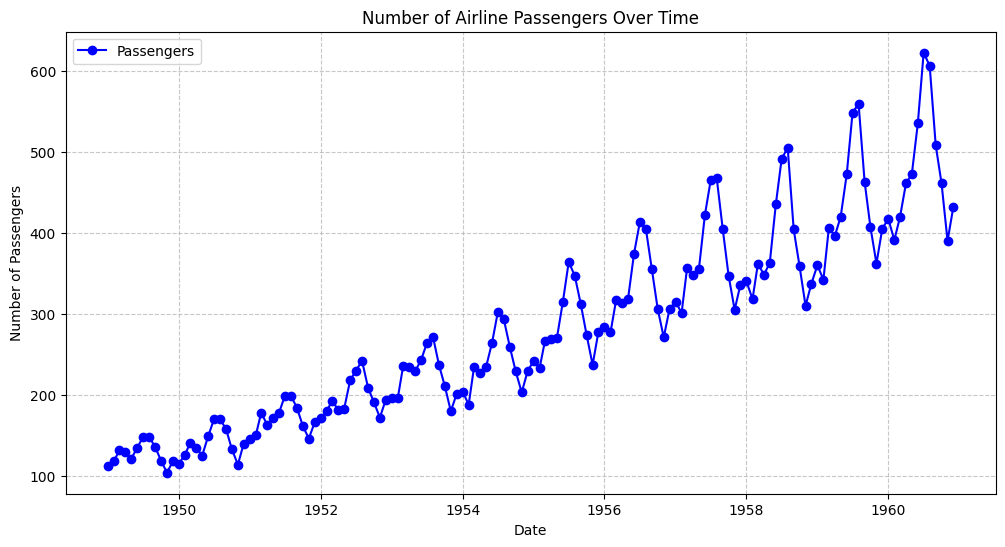

In [56]:
df['Month'] = pd.to_datetime(df['Month'])

plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Passengers'], marker='o', color='b', label='Passengers')
plt.title('Number of Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### 1) Предобработка данных

In [57]:
scaler = MinMaxScaler()
df['Passengers'] = scaler.fit_transform(df[['Passengers']])
data = df['Passengers'].values

### 2) Создание датасета

In [58]:
def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length):
    X.append(data[i:i + seq_length])
    y.append(data[i + seq_length])
  return np.array(X), np.array(y)

seq_length = 25
data = np.sin(np.linspace(0, 50, 500))
scaler = MinMaxScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

X, y = create_sequences(data, seq_length)
X = np.expand_dims(X, axis=1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')

X_train shape: torch.Size([380, 1, 25]), y_train shape: torch.Size([380, 1])


### 3) Создание нейронной сети

In [59]:
class TimeSeriesCNN(nn.Module):
    def __init__(self):
        super(TimeSeriesCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 5, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### 4) ModelCheckpoint

In [60]:
class ModelCheckpoint:
    def __init__(self, filepath, monitor="val_loss", mode="min", verbose=True):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best_score = None
        self.verbose = verbose

    def save_checkpoint(self, model, epoch, val_score):
        if self.best_score is None or (
            self.mode == 'min' and val_score < self.best_score or
            self.mode == 'max' and val_score > self.best_score
        ):
            self.best_score = val_score
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"✅ Модель сохранена на эпохе {epoch+1} с {self.monitor}: {val_score:.4f}")


### 5) EarlyStopping

In [61]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### 6) Обучение модели

In [62]:
model = TimeSeriesCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
checkpoint = ModelCheckpoint(filepath="best_model.pth", monitor="val_loss", mode="min")
early_stopping = EarlyStopping(patience=7, min_delta=0.001)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in tqdm(train_loader, desc=f"Эпоха {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)

    print(f"Эпоха [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    checkpoint.save_checkpoint(model, epoch, val_loss)

    if early_stopping.should_stop(val_loss):
        print("🛑 Раннее прекращение обучения.")
        break

model.load_state_dict(torch.load("best_model.pth"))

Эпоха 1/50: 100%|██████████| 12/12 [00:00<00:00, 139.43it/s]


Эпоха [1/50] - Train Loss: 0.2355, Val Loss: 0.1157
✅ Модель сохранена на эпохе 1 с val_loss: 0.1157


Эпоха 2/50: 100%|██████████| 12/12 [00:00<00:00, 166.48it/s]


Эпоха [2/50] - Train Loss: 0.1177, Val Loss: 0.0934
✅ Модель сохранена на эпохе 2 с val_loss: 0.0934


Эпоха 3/50: 100%|██████████| 12/12 [00:00<00:00, 171.87it/s]


Эпоха [3/50] - Train Loss: 0.0878, Val Loss: 0.0716
✅ Модель сохранена на эпохе 3 с val_loss: 0.0716


Эпоха 4/50: 100%|██████████| 12/12 [00:00<00:00, 156.19it/s]


Эпоха [4/50] - Train Loss: 0.0533, Val Loss: 0.0300
✅ Модель сохранена на эпохе 4 с val_loss: 0.0300


Эпоха 5/50: 100%|██████████| 12/12 [00:00<00:00, 165.81it/s]


Эпоха [5/50] - Train Loss: 0.0145, Val Loss: 0.0017
✅ Модель сохранена на эпохе 5 с val_loss: 0.0017


Эпоха 6/50: 100%|██████████| 12/12 [00:00<00:00, 144.82it/s]


Эпоха [6/50] - Train Loss: 0.0009, Val Loss: 0.0016
✅ Модель сохранена на эпохе 6 с val_loss: 0.0016


Эпоха 7/50: 100%|██████████| 12/12 [00:00<00:00, 196.08it/s]


Эпоха [7/50] - Train Loss: 0.0008, Val Loss: 0.0001
✅ Модель сохранена на эпохе 7 с val_loss: 0.0001


Эпоха 8/50: 100%|██████████| 12/12 [00:00<00:00, 201.07it/s]


Эпоха [8/50] - Train Loss: 0.0002, Val Loss: 0.0001


Эпоха 9/50: 100%|██████████| 12/12 [00:00<00:00, 178.32it/s]


Эпоха [9/50] - Train Loss: 0.0001, Val Loss: 0.0000
✅ Модель сохранена на эпохе 9 с val_loss: 0.0000


Эпоха 10/50: 100%|██████████| 12/12 [00:00<00:00, 200.19it/s]


Эпоха [10/50] - Train Loss: 0.0000, Val Loss: 0.0000
✅ Модель сохранена на эпохе 10 с val_loss: 0.0000


Эпоха 11/50: 100%|██████████| 12/12 [00:00<00:00, 198.02it/s]


Эпоха [11/50] - Train Loss: 0.0000, Val Loss: 0.0000
✅ Модель сохранена на эпохе 11 с val_loss: 0.0000


Эпоха 12/50: 100%|██████████| 12/12 [00:00<00:00, 201.13it/s]


Эпоха [12/50] - Train Loss: 0.0000, Val Loss: 0.0000


Эпоха 13/50: 100%|██████████| 12/12 [00:00<00:00, 205.18it/s]


Эпоха [13/50] - Train Loss: 0.0000, Val Loss: 0.0000
✅ Модель сохранена на эпохе 13 с val_loss: 0.0000


Эпоха 14/50: 100%|██████████| 12/12 [00:00<00:00, 199.78it/s]

Эпоха [14/50] - Train Loss: 0.0000, Val Loss: 0.0000
✅ Модель сохранена на эпохе 14 с val_loss: 0.0000
🛑 Раннее прекращение обучения.


<All keys matched successfully>

### 5) Оценка и прогнозирование

RMSE: 0.01


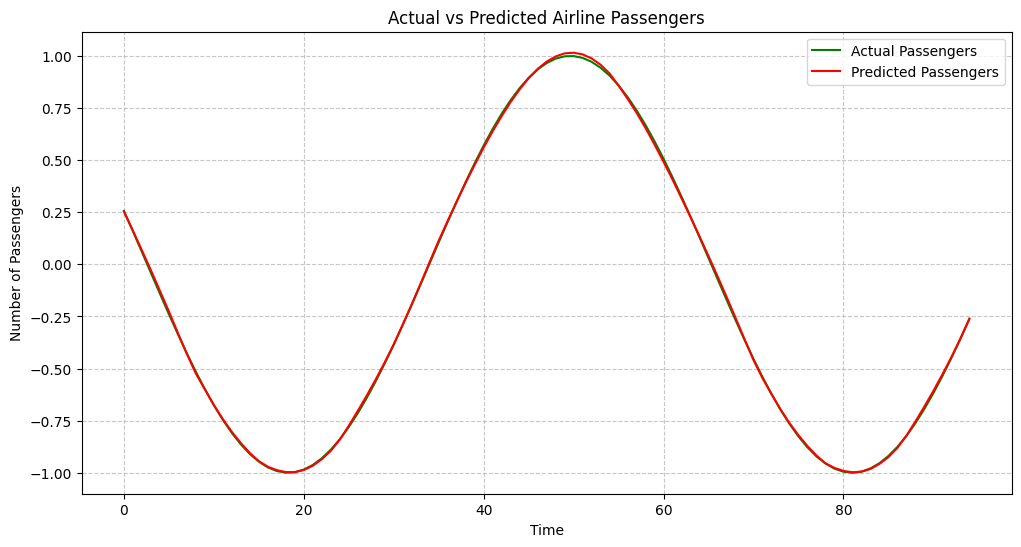

In [63]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.numpy())

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f'RMSE: {rmse:.2f}')

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Passengers', color='g')
plt.plot(predictions, label='Predicted Passengers', color='r')
plt.title('Actual vs Predicted Airline Passengers')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()